# Visualisation

A tutorial for the Visualisation class.

#### Visualisation initialisation
- model
    - prob(X, y)
        - Probability of y given X
    - sample(X)
        - Sample y given X
    - sample_fixed(X_fixed)
        - Sample y given fixed X
- X
- y 
    
#### Visualisation methods
- plot_prob(X1, X2)
    - Plot the density function based on X1 and X2.
- plot_prob_fixed(X_fixed, y_range)
    - Plot probability density function given X_fixed across y_range.
- plot_violin(density1, density2)
    - Plot a violin to compare 2 densities.
- plot_prob_violin(X_fixed, X_tol)
    - Given X, plot a violin of y based on X within a tolerance, to compare between fitted and actual.
- plot_binned_violin()
    - Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

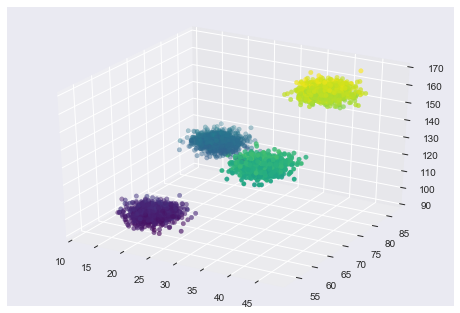

In [3]:
from data.synthetic import plot_data, get_normal_data

X, y = get_normal_data(1000, xy_features=(2,1))
plot_data(X, y)

n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(32)

# Sample Model: GMM

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 10)           30          input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 4)            44          dense_8[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 4)            44          dense_8[0][0]                    
____________________________________________________________________________________________

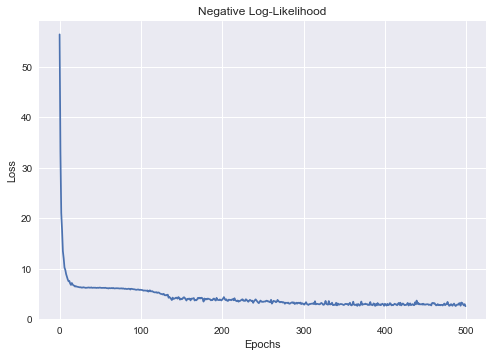

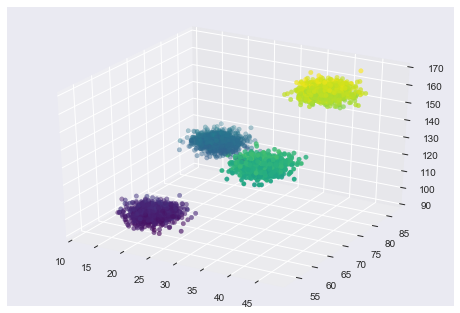

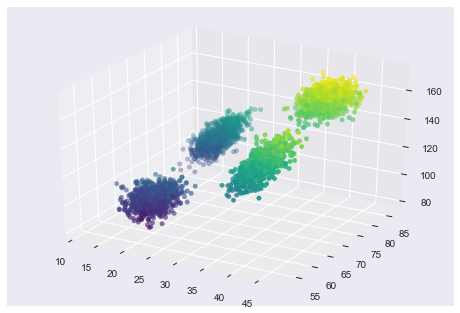

In [13]:
from model.gmm import GMM

gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=4,
          n_hidden=10)

gmm.fit(dataset, epochs=500, plot=True, verbose=True, logdir='gmm_viz')
y_hat = gmm.sample(X)

plot_data(X, y)
plot_data(X, y_hat)

# Visualisation

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.stats import binned_statistic

class Visualisation:
    """
    Model must have the following methods:
        - prob(X, y)             # probability of y given X
        - sample(X)              # sample y given X
        - sample_fixed(X_fixed)  # sample y given fixed X
    """
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
    
    def plot_prob(self, X1, X2, bins=20):
        """Plot the density function based on X1 and X2."""
        pdf, x1, x2 = np.histogram2d(X1, X2, bins=bins, density=True)
        xmesh, ymesh = np.meshgrid(x1[:-1], x2[:-1])
        ax = plt.axes(projection='3d')
        ax.plot_surface(xmesh, ymesh, pdf, cmap='viridis')
        plt.show()
    
    def plot_prob_fixed(self, X_fixed, y_range, count=20):
        """Plot probability density function given X_fixed across y_range."""
        assert hasattr(self.model, 'prob')
        X = np.stack([np.full(count, fill_value=x) for x in X_fixed], axis=1)
        y = np.linspace(y_range[0], y_range[1], count)

        y_prob = self.model.prob(X, y)
        plt.title(f"X={X_fixed}, y={y_range}")
        plt.plot(y, y_prob)
        plt.show()
    
    def plot_violin(self, density1, density2, feature="", ax=None):
        """Plot a violin to compare 2 densities."""
        df = pd.DataFrame({
            'density': np.concatenate([density1, density2]),
            'feature': [feature] * len(density1) * 2,
            'distribution': ["actual"] * len(density1) + ["fitted"] * len(density2)
        })
        if ax is None:
            sns.violinplot(x="feature", y="density", hue="distribution", data=df, split=True)
            plt.show()
        else:
            sns.violinplot(x="feature", y="density", hue="distribution", data=df, split=True, ax=ax)
        return df
    
    def plot_prob_violin(self, X_fixed, X_tol):
        """Given X, plot a violin of y based on X within a tolerance, to compare between fitted and actual."""
        assert hasattr(self.model, 'sample')
        # Get indices where X lies within X_tol of X_fixed
        X_idx = [np.where(np.abs(self.X[:,i] - X_fixed[i]) < X_tol[i])[0] for i in range(self.X.shape[1])]
        idx = reduce(np.intersect1d, X_idx)
        assert len(idx) > 0

        # Sample based on X_fixed
        X_fix = np.stack([np.full(len(idx), fill_value=x) for x in X_fixed], axis=1)
        y_hat = self.model.sample(self.X[idx])

        # Plot violins depending on y dimension
        for y_dim in range(self.y.shape[1]):
            self.plot_violin(self.y[idx, y_dim], y_hat[:,y_dim], feature=f"X={X_fixed}, Count={len(idx)}")
    
    def plot_binned_violin(self, bins=5):
        """Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
        For the actual distribution, bin X and plot violin plots for the density of y.
        For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
        """
        assert self.y.shape[1] == 1
        assert hasattr(self.model, 'sample')
        # X is 2D
        if selfX.shape[1] == 2:
            # Bin X values to get probabilities of y given X
            X0_bin = binned_statistic(self.X[:,0], self.X[:,0], bins=bins)
            X1_bin = binned_statistic(self.X[:,1], self.X[:,1], bins=bins)
            fig, ax = plt.subplots(bins, bins, figsize=(20,12))

            for x0 in range(bins):
                for x1 in range(bins):
                    # Get indices where X belong to each bin
                    idx = np.intersect1d(np.where(X0_bin[2]==x0+1)[0], np.where(X1_bin[2]==x1+1)[0])
                    if len(idx) > 0:
                        # Given the mean
                        y_hat = self.model.sample(self.X[idx])
                        self.plot_violin(self.y[idx,0], y_hat[:,0], f"X=({round(X0_bin[0][x0],2)},{round(X1_bin[0][x1],2)}), Count={len(idx)}", ax[x0,x1])
        # X is 1D
        if self.X.shape[1] == 1:
            X0_bin = binned_statistic(self.X[:,0], self.X[:,0], bins=bins)
            fig, ax = plt.subplots(1, bins, figsize=(20,12))
            for x0 in range(bins):
                idx = np.where(X0_bin[2]==x0+1)[0]
                if len(idx) > 0:
                    y_hat = self.model.sample(self.X[idx])
                    self.plot_violin(self.y[idx,0], y_hat[:,0], f"X=({round(X0_bin[0][x0],2)},), Count={len(idx)}", ax[x0])

In [15]:
viz = Visualisation(gmm, X, y)

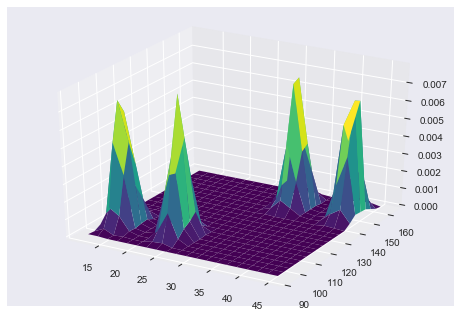

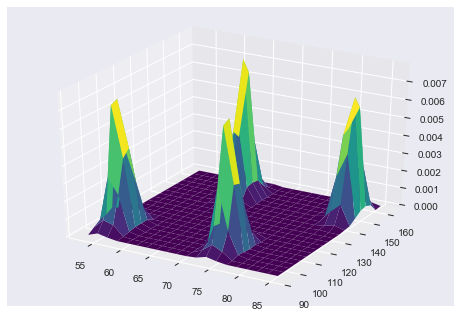

In [16]:
# Plot the density function based on X1 and X2
viz.plot_prob(X[:,0], y[:,0], bins=20)
viz.plot_prob(X[:,1], y[:,0], bins=20)

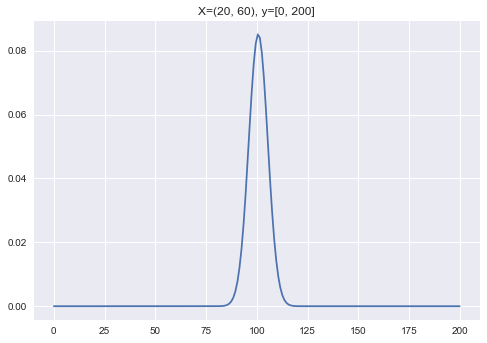

In [17]:
# Plot probability density function given X_fixed across y_range.
viz.plot_prob_fixed(X_fixed=(20,60), y_range=[0,200], count=200)

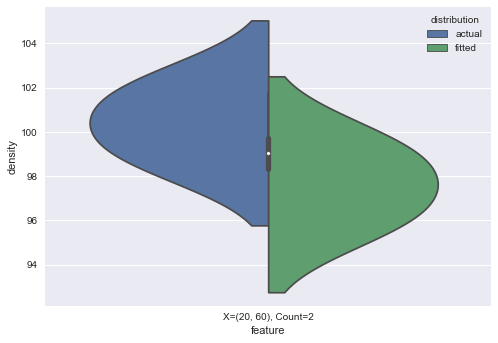

In [18]:
# Given X, plot a violin of y based on X within a tolerance, to compare the distribution between fitted and actual.
# X_tol represents the tolerance to which X data is binned to get the corresponding y.
# X_fixed represents the X fed into the model to sample y.
viz.plot_prob_violin(X_fixed=(20,60), X_tol=(0.1,0.1))

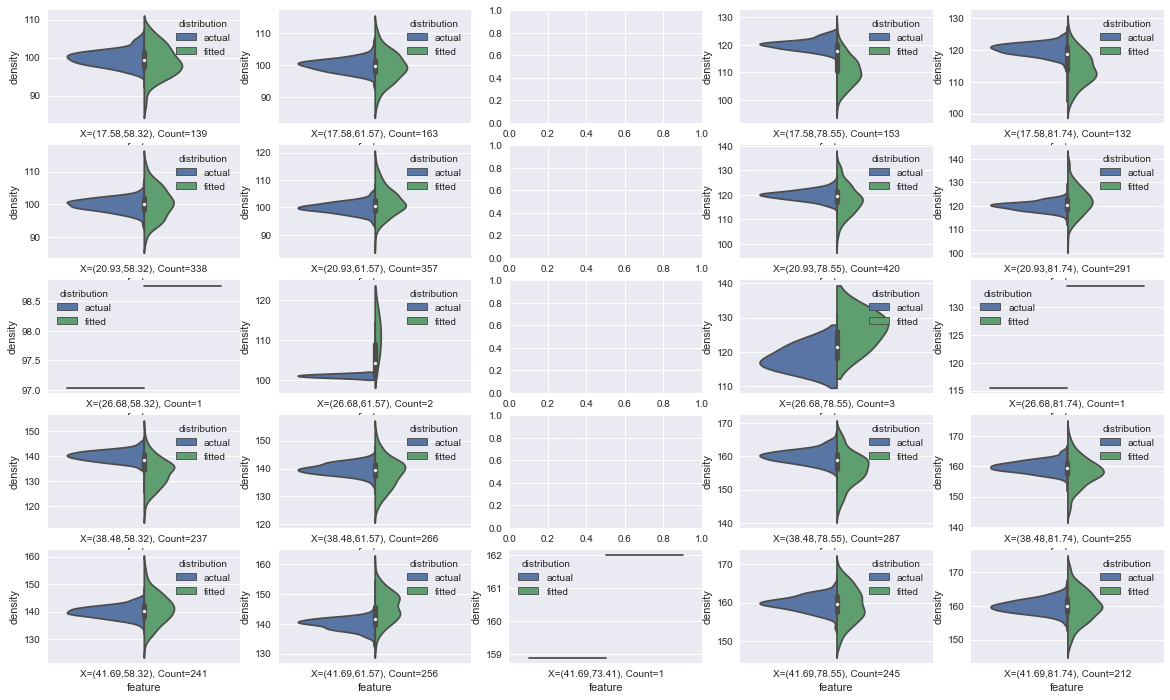

In [19]:
# Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
# For the actual distribution, bin X and plot violin plots for the density of y.
# For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
viz.plot_binned_violin(bins=5)